# VAE on HSC images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from datasets import load_from_disk

from galgenai import VAE, get_device, get_device_name


device = get_device()
print(f"Using device: {get_device_name()}")

Using device: mps


## Load and inspect data

In [ ]:
dataset_raw = load_from_disk("../data/hsc_mmu_mini/")
dataset_raw = dataset_raw.select_columns(["image"]).with_format("torch")

n_gals = len(dataset_raw)
bands = dataset_raw[0]["image"]["band"]

# dataset.set_transform(lambda data: {"flux": data["image"]["flux"]})
# dataset = dataset.map(lambda x: {"flux": x["image"]["flux"]}, remove_columns=["image"])

# min/max
mins = torch.Tensor(-2 * np.ones(len(bands)))
maxs = torch.Tensor(99 * np.ones(len(bands)))


class FluxDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        hf_dataset,
        nx: int,
        mins: torch.TensorType,
        maxs: torch.TensorType,
    ):
        self.dataset = hf_dataset

        # crop to 128
        self.og_nx2 = self.dataset[0]["image"]["flux"].shape[1] // 2
        self.og_ny2 = self.dataset[0]["image"]["flux"].shape[2] // 2
        self.mins = mins[:, None, None]
        self.maxs = maxs[:, None, None]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_data = self.dataset[idx]["image"]

        # Extract and crop flux
        flux = image_data["flux"][
            :,
            self.og_nx2 - 64 : self.og_nx2 + 64,
            self.og_ny2 - 64 : self.og_ny2 + 64,
        ]
        flux_normalized = (flux - self.mins) / (self.maxs - self.mins)

        # Extract and crop inverse variance
        ivar = image_data["ivar"][
            :,
            self.og_nx2 - 64 : self.og_nx2 + 64,
            self.og_ny2 - 64 : self.og_ny2 + 64,
        ]

        # Extract and crop mask
        mask = image_data["mask"][
            :,
            self.og_nx2 - 64 : self.og_nx2 + 64,
            self.og_ny2 - 64 : self.og_ny2 + 64,
        ]

        return flux_normalized, ivar, mask


dataset = FluxDataset(dataset_raw, nx=128, mins=mins, maxs=maxs)
n_bands, n_x, n_y = dataset[0][0].shape  # First element of tuple is flux
assert n_x == n_y
assert len(bands) == n_bands
print(f"Images dimension: {n_bands}*{n_x}*{n_y} ({n_gals} galaxies)")

Images dimension: 5*128*128 (1000 galaxies)


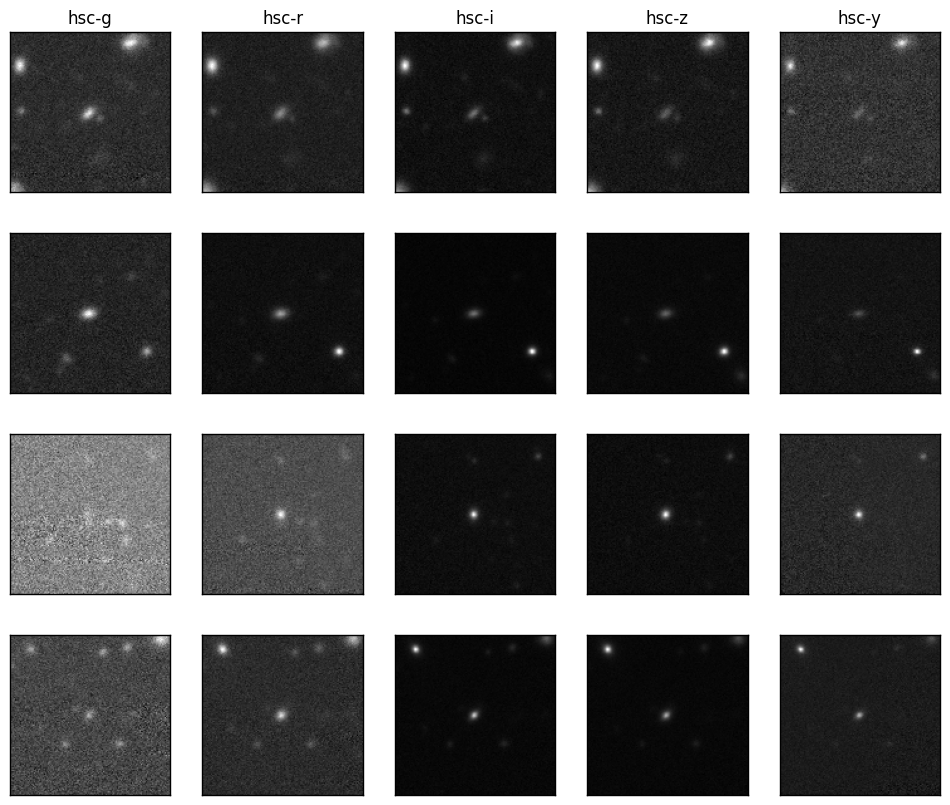

In [ ]:
_n_plot = 4
fig, axs = plt.subplots(_n_plot, n_bands, figsize=(12, 10))

for i in range(_n_plot):
    axs_row = axs[i]
    flux, ivar, mask = dataset[i]
    for im, band, ax in zip(flux, bands, axs_row, strict=True):
        ax.imshow(im, origin="lower", cmap="gray")
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        if i == 0:
            ax.set_title(band)

## Define model

In [ ]:
model = VAE(in_channels=n_bands, latent_dim=32, input_size=n_x).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

Model parameters: 66,840,469


In [ ]:
x = torch.randn(4, n_bands, n_x, n_y).to(device)  # batch
print(f"Input shape: {x.shape}")

reconstruction, mu, logvar = model(x)
print(f"Reconstruction shape: {reconstruction.shape}")
print(f"Latent mean shape: {mu.shape}")
print(f"Latent log variance shape: {logvar.shape}")

Input shape: torch.Size([4, 5, 128, 128])
Reconstruction shape: torch.Size([4, 5, 128, 128])
Latent mean shape: torch.Size([4, 32])
Latent log variance shape: torch.Size([4, 32])


## Check pre-training outputs

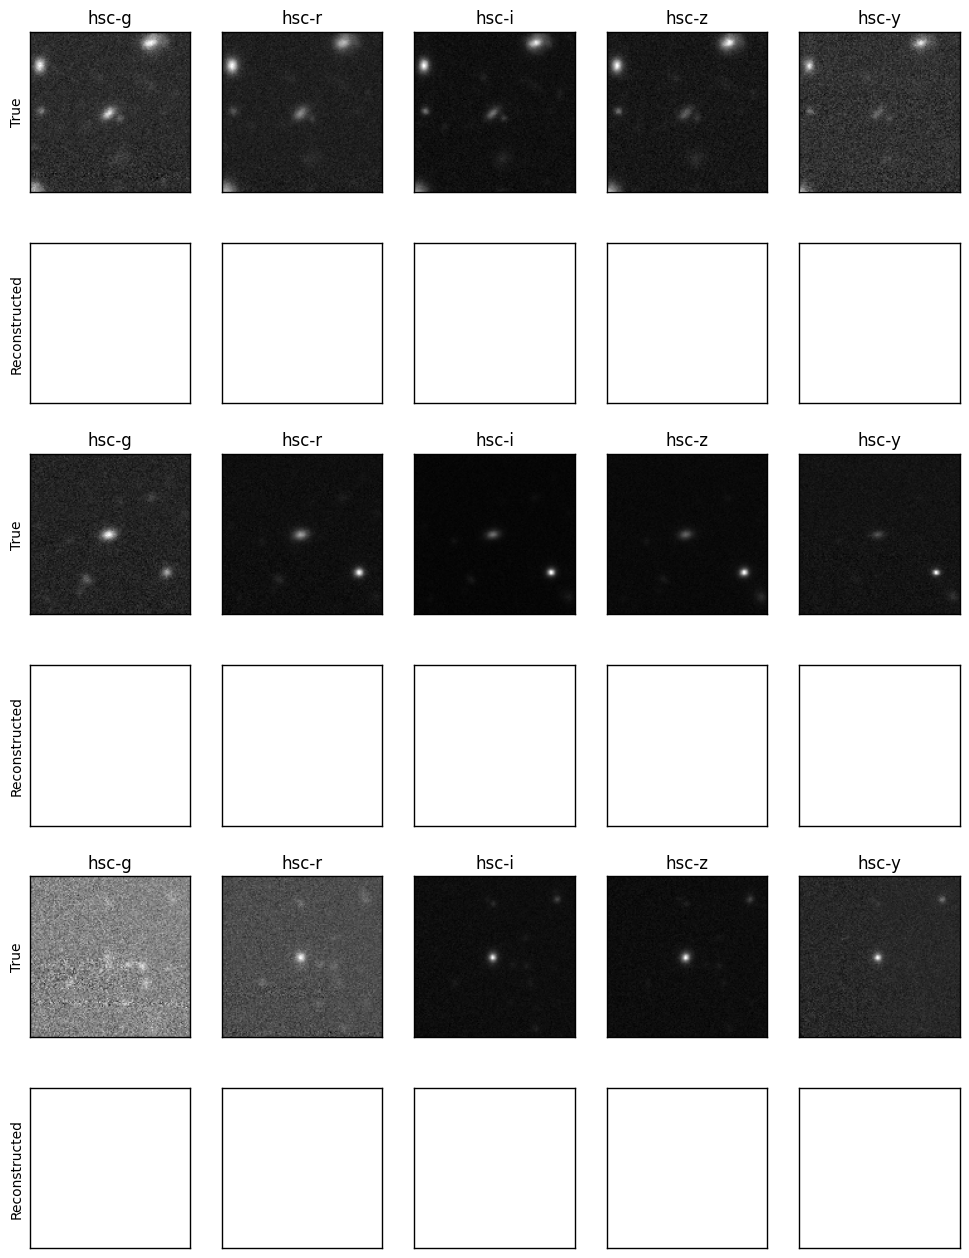

In [ ]:
model.eval()
_n_plot = 3

# Extract only flux (first element of tuple) for visualization
imgs = torch.stack([dataset[i][0] for i in range(4)]).to(device)
with torch.no_grad():
    recs, _, _ = model(imgs)

fig, axs = plt.subplots(_n_plot * 2, n_bands, figsize=(12, 16))
for i in range(_n_plot):
    axs_row_true = axs[2 * i]
    axs_row_reco = axs[2 * i + 1]

    axs_row_true[0].set_ylabel("True")
    axs_row_reco[0].set_ylabel("Reconstructed")

    for j, band in enumerate(bands):
        minmax = {
            "vmin": imgs[i, j].cpu().min(),
            "vmax": imgs[i, j].cpu().max(),
        }
        axs_row_true[j].imshow(
            imgs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )
        axs_row_reco[j].imshow(
            recs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )

        axs_row_true[j].xaxis.set_ticks([])
        axs_row_true[j].yaxis.set_ticks([])
        axs_row_reco[j].xaxis.set_ticks([])
        axs_row_reco[j].yaxis.set_ticks([])
        axs_row_true[j].set_title(band)

## Train

In [ ]:
from torch.utils.data import DataLoader, random_split
from galgenai.training import train

BATCH_SIZE = 256
NUM_WORKERS = 0
NUM_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75)

dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_loader = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    reconstruction_loss_fn="masked_weighted_mse",
    beta=1.0,
)

Training on device: mps
Number of epochs: 10
Reconstruction loss: masked_weighted_mse
Beta: 1.0
Learning rate scheduler: ExponentialLR
------------------------------------------------------------

Epoch 1/10 (lr: 0.001000)


Training: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it, loss=9679757312.0000, recon=75419032.0000, kl=9604338688.0000]                       


Epoch 1 Summary - Total Loss: 158272622518629920.0000, Recon Loss: 62786579383414.0000, KL Loss: 158209830033666560.0000

Epoch 2/10 (lr: 0.000750)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.13s/it, loss=59346684.0000, recon=59329516.0000, kl=17168.6895]                             


Epoch 2 Summary - Total Loss: 111446265149412608.0000, Recon Loss: 5491705027563.0000, KL Loss: 111440772923650304.0000

Epoch 3/10 (lr: 0.000563)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.14s/it, loss=557616576.0000, recon=79433040.0000, kl=478183552.0000]            


Epoch 3 Summary - Total Loss: 26250511362928.0000, Recon Loss: 83669964.0000, KL Loss: 26250428135968.0000

Epoch 4/10 (lr: 0.000422)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it, loss=61758580.0000, recon=61710792.0000, kl=47786.6602]         


Epoch 4 Summary - Total Loss: 20217502429.0000, Recon Loss: 79611166.0000, KL Loss: 20137891242.6650

Epoch 5/10 (lr: 0.000316)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it, loss=65635988.0000, recon=65342592.0000, kl=293397.5938]    


Epoch 5 Summary - Total Loss: 194794187.0000, Recon Loss: 78699218.0000, KL Loss: 116094971.3984

Epoch 6/10 (lr: 0.000237)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.17s/it, loss=76430672.0000, recon=76429368.0000, kl=1302.1089]    


Epoch 6 Summary - Total Loss: 85572844.0000, Recon Loss: 80815460.0000, KL Loss: 4757383.2616

Epoch 7/10 (lr: 0.000178)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.17s/it, loss=85650992.0000, recon=85616552.0000, kl=34441.2188]  


Epoch 7 Summary - Total Loss: 82105742.0000, Recon Loss: 81611314.0000, KL Loss: 494427.3086

Epoch 8/10 (lr: 0.000133)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.19s/it, loss=70009504.0000, recon=70006816.0000, kl=2691.4963]  


Epoch 8 Summary - Total Loss: 75413874.0000, Recon Loss: 75267286.0000, KL Loss: 146589.5987

Epoch 9/10 (lr: 0.000100)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.14s/it, loss=54682172.0000, recon=54680296.0000, kl=1876.9449] 


Epoch 9 Summary - Total Loss: 69363137.0000, Recon Loss: 69348120.0000, KL Loss: 15017.7648

Epoch 10/10 (lr: 0.000075)


Training: 100%|██████████| 4/4 [00:12<00:00,  3.17s/it, loss=81795936.0000, recon=81794000.0000, kl=1934.4938]  

Epoch 10 Summary - Total Loss: 75148874.0000, Recon Loss: 75015512.0000, KL Loss: 133361.8039


## Check post-training outputs

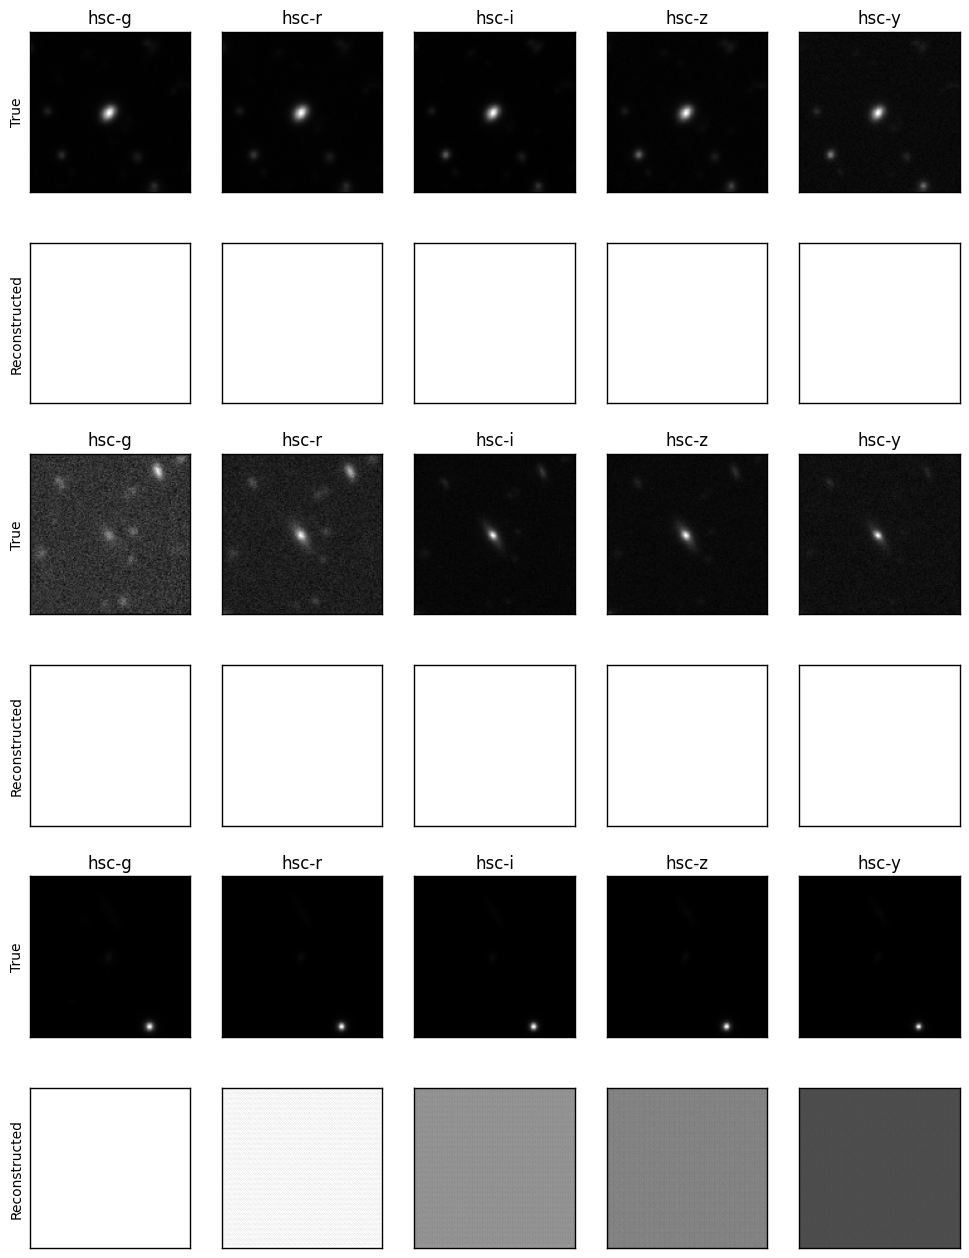

In [ ]:
model.eval()
_n_plot = 3

# Extract only flux (first element of tuple) for visualization
imgs = torch.stack([dataset_test[i][0] for i in range(4)]).to(device)
with torch.no_grad():
    recs, _, _ = model(imgs)

fig, axs = plt.subplots(_n_plot * 2, n_bands, figsize=(12, 16))
for i in range(_n_plot):
    axs_row_true = axs[2 * i]
    axs_row_reco = axs[2 * i + 1]

    axs_row_true[0].set_ylabel("True")
    axs_row_reco[0].set_ylabel("Reconstructed")

    for j, band in enumerate(bands):
        minmax = {
            "vmin": imgs[i, j].cpu().min(),
            "vmax": imgs[i, j].cpu().max(),
        }
        axs_row_true[j].imshow(
            imgs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )
        axs_row_reco[j].imshow(
            recs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )

        axs_row_true[j].xaxis.set_ticks([])
        axs_row_true[j].yaxis.set_ticks([])
        axs_row_reco[j].xaxis.set_ticks([])
        axs_row_reco[j].yaxis.set_ticks([])
        axs_row_true[j].set_title(band)

In [ ]:
# Debug: check max values
# flux, ivar, mask = dataset[0]
# flux.max()